# 00-basedata: Get vertices from all espacios públicos in Guadalajara

This iterates over each Polygon / Multipolygon, extracts its vertices and saves them to a new GDF in the database for use in project Volvo.

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/jovyan/accesibilidad-urbana/aup/data.py:25: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


## Load data

In [2]:
# Points of interest - Espacio publico (Parques) ### Exclusive project Volvo
parques_schema = 'espacios_publicos' 
parques_table = 'ep_amg'

In [5]:
####################################################################################################################################
# NEW
# Project Volvo includes 'parques', which are in OdC's DB
####################################################################################################################################
def get_parques_pois(parques_schema,parques_table):
    # This function creates parques points of interest out of vertices of parques found in db (schema>table)

    # Download parques pois
    query = f"SELECT * FROM {parques_schema}.{parques_table}"
    code_pois = aup.gdf_from_query(query, geometry_col='geometry')

    # Format parques pois
    #code_pois = code_pois[['codigo_act', 'geometry']]
    #code_pois = code_pois.rename(columns={'codigo_act':'code'})
    #code_pois['code'] = code_pois['code'].astype('int64')

    return code_pois

In [6]:
gdf = get_parques_pois(parques_schema,parques_table)
gdf['geom_type'] = gdf.geom_type

# Show
print(gdf.shape)
gdf.head(2)

(8499, 5)


,Fuente,Tipo,Uso,geometry,geom_type
0,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672507.028 2272132.201, 672520.126 2...",Polygon
1,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672520.126 2272170.353, 672507.028 2...",Polygon


<Axes: >

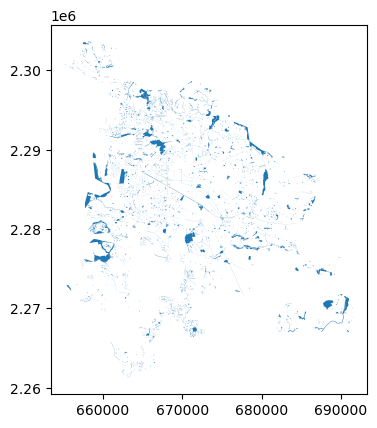

In [7]:
gdf.plot()

## Get vertices from Multipolygons/Polygons

In [9]:
from shapely.geometry import Point

# Show original columns
col = gdf.columns.tolist()
print(col)

# To create new GeoDataFrame with same columns
nodes = gpd.GeoDataFrame(columns=col)

# Extraction of the polygon nodes and attributes values from polys and integration into the new GeoDataFrame
tmp_gdf = gpd.GeoDataFrame()

i = 1 
# For each row (polygon)
for index, row in gdf.iterrows():

    print(f'STARTING row {i}/{len(gdf)}.')

    # If it is a multypolygon, extract polygon, extract vertices
    if row['geom_type'] == 'MultiPolygon':
        
        print(f'Row {i} is MultiPolygon.')
        
        j = 1
        for poly in list(row.geometry.geoms):

            print(f'Starting Polygon {j}/{len(list(row.geometry.geoms))} for row {i}.')
            
            # For each point of polygon
            for coord in list(poly.exterior.coords):
                
                # Add polygon data
                tmp_gdf.loc[0,'Fuente'] = row['Fuente']
                tmp_gdf.loc[0,'Tipo'] = row['Tipo']
                tmp_gdf.loc[0,'Uso'] = row['Uso']

                # Add point data
                tmp_gdf.loc[0,'geometry'] = Point(coord)
                
                # Add to nodes gdf
                nodes = pd.concat([nodes,tmp_gdf],ignore_index=True)

            j = j+1
                
    # If it is a polygon, extract vertices
    else:
        # For each point of polygon
        poly_coords = list(row['geometry'].exterior.coords)
        for coord in poly_coords:
            
            # Add polygon data
            tmp_gdf.loc[0,'Fuente'] = row['Fuente']
            tmp_gdf.loc[0,'Tipo'] = row['Tipo']
            tmp_gdf.loc[0,'Uso'] = row['Uso']
            
            # Add point data
            tmp_gdf.loc[0,'geometry'] = Point(coord)
            
            # Add to nodes gdf
            nodes = pd.concat([nodes,tmp_gdf],ignore_index=True)

    i = i+1
        
print(nodes.shape)
nodes.head(2)

['Fuente', 'Tipo', 'Uso', 'geometry', 'geom_type']
STARTING row 1/8499.
STARTING row 2/8499.
STARTING row 3/8499.
STARTING row 4/8499.
STARTING row 5/8499.
STARTING row 6/8499.
STARTING row 7/8499.
STARTING row 8/8499.
STARTING row 9/8499.
STARTING row 10/8499.
STARTING row 11/8499.
STARTING row 12/8499.
STARTING row 13/8499.
STARTING row 14/8499.
STARTING row 15/8499.
STARTING row 16/8499.
STARTING row 17/8499.
STARTING row 18/8499.
STARTING row 19/8499.
STARTING row 20/8499.
STARTING row 21/8499.
STARTING row 22/8499.
STARTING row 23/8499.
STARTING row 24/8499.
STARTING row 25/8499.
STARTING row 26/8499.
STARTING row 27/8499.
STARTING row 28/8499.
STARTING row 29/8499.
STARTING row 30/8499.
STARTING row 31/8499.
STARTING row 32/8499.
STARTING row 33/8499.
STARTING row 34/8499.
STARTING row 35/8499.
STARTING row 36/8499.
STARTING row 37/8499.
STARTING row 38/8499.
STARTING row 39/8499.
STARTING row 40/8499.
STARTING row 41/8499.
STARTING row 42/8499.
STARTING row 43/8499.
STARTING row

,Fuente,Tipo,Uso,geometry,geom_type
0,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,POINT (672507.028 2272132.201),NaN
1,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,POINT (672520.126 2272170.353),NaN


## Evaluate result

<Axes: >

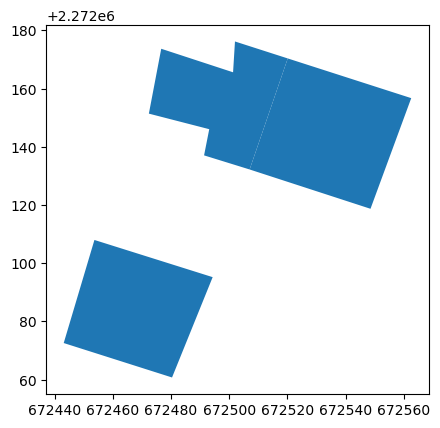

In [37]:
poly_test = gdf.loc[(0,1,2),]
poly_test.plot()

In [38]:
nodes.set_crs("EPSG:32613",inplace=True)
nodes_test = gpd.sjoin(nodes,poly_test)
nodes_test.shape

(28, 10)

In [39]:
nodes_test_f = nodes_test.drop_duplicates()
nodes_test_f.shape

(16, 10)

<Axes: >

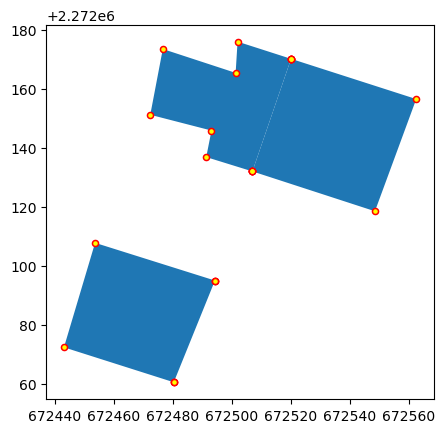

In [40]:
fig,ax=plt.subplots(figsize=(5,5))

poly_test.plot(ax=ax,zorder=0)
nodes_test.plot(ax=ax,zorder=1,c='red',markersize=20)
nodes_test_f.plot(ax=ax,zorder=1,c='yellow',markersize=5)

## Drop duplicates

In [44]:
nodes.set_crs("EPSG:32613",inplace=True)
nodes_dropdups = nodes.drop_duplicates()
nodes_dropdups['geom_type'] = nodes_dropdups.geom_type

# Show
print(nodes_dropdups.geom_type.unique())
print(nodes_dropdups.shape)
nodes_dropdups.head(2)

['Point']
(266292, 5)


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,Fuente,Tipo,Uso,geometry,geom_type
0,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,POINT (672507.028 2272132.201),Point
1,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,POINT (672520.126 2272170.353),Point


## Save and last test

In [45]:
save_schema = 'espacios_publicos' 
save_table = 'ep_amg_year_vertices'

aup.gdf_to_db_slow(nodes_dropdups, save_table, save_schema, if_exists='append')

In [46]:
# Test - load parques vertices pois
query = f"SELECT * FROM {save_schema}.{save_table}"
load_test = aup.gdf_from_query(query, geometry_col='geometry')

In [47]:
# Show
print(load_test.crs)
print(load_test.shape)
load_test.head(2)

epsg:32613
(266292, 5)


,Fuente,Tipo,Uso,geometry,geom_type
0,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,POINT (672507.028 2272132.201),Point
1,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,POINT (672520.126 2272170.353),Point
